## MTH9899 Machine Learning
### Assignment 02
### Xinlu Xiao: xinluxiao.baruch@gmail.com

### Problem1

Derive the formula: $$ \sigma^2(\bar{\hat{y}}) = \rho \sigma^2_{\hat{y_i}} + \frac{1-\rho}{B} \sigma^2_{\hat{y_i}}$$
Where $\rho$ is the correlation between any predictors and $B$ represents the number of predictors.

<font color="red">
#### Solution:

Since we know that $$\bar{\hat{y}} = \frac{1}{B} \sum \hat{y_i}$$

And assume that the mean of the predictors is $\mu$, and the variance of the predictors is $\sigma^2$.

Then 
\begin{align}
\sigma^2(\bar{\hat{y}}) &= Var(\frac{1}{B} \sum \hat{y_i}) \\
                        &=\frac{1}{B^2} Var(\sum \hat{y_i})\\
                        &=\frac{1}{B^2}(E[(\sum_{i} \hat{y_i})^2] - E^2[\sum_i \hat{y_i}])\\
\end{align}

Since we know that $$E[\sum_i \hat{y_i}] = B \mu, E^2[\sum_i \hat{y_i}] = B^2 \mu^2$$
And 
\begin{align}
E[(\sum_{i} \hat{y_i})^2] &= \sum E(\hat{y_i}^2) + \sum_{i \neq j} E(\hat{y_i} \hat{y_j}) \\
                          &= B(\mu^2 + \sigma^2) + (B^2-B)(\rho \sigma^2 + \mu^2)\\
                          &= B \sigma^2+B^2\rho \sigma^2 + B^2 \mu^2 - B\rho \sigma^2
\end{align}
Finally, we can get the conclusion:
\begin{align}
\sigma^2(\bar{\hat{y}}) &= \frac{1}{B^2}(B \sigma^2+B^2\rho \sigma^2 + B^2 \mu^2 - B\rho \sigma^2 - B^2 \mu^2)\\
                        &= \rho \sigma^2 + \frac{1-\rho}{B} \sigma^2 \\
                        &= \rho \sigma^2_{\hat{y_i}} + \frac{1-\rho}{B} \sigma^2_{\hat{y_i}}
\end{align}

### Problem2

In [14]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# given code
class TreeNode:     
    def predict(x, y):
        assert False

    def depth(self):
        assert False

class BranchNode(TreeNode):
    def __init__(self, left, right, split_var_index, split_var_value):
        self.left = left
        self.right = right
        self.split_var_index = split_var_index
        self.split_var_value = split_var_value

    def predict(self, x):
        svar = x[:, self.split_var_index]
        is_left = svar < self.split_var_value
        leftx = x[is_left]
        rightx = x[~is_left]

        rv = np.zeros(x.shape[0])
        rv[is_left] = self.left.predict(leftx)
        rv[~is_left] = self.right.predict(rightx)

        return rv

    def depth(self):
        return 1 + max(self.left.depth(), self.right.depth())

class LeafNode(TreeNode):
    def __init__(self, mu):
        self.mu = mu

    def predict(self, x):
        return np.repeat(self.mu, x.shape[0])

    def depth(self):
        return 1

In [34]:
class RegressionTree:
    def __init__(self, max_depth, min_points_in_leaf, num_cv_folds):
        self.max_depth = max_depth
        self.min_points_in_leaf = min_points_in_leaf
        self.num_cv_folds = num_cv_folds

    def predict(self, x):
        assert self.fitted
        return self.root.predict(x)

    def fit(self, x, y):
        self.fitted = True
        self.root = self.fit_internal(x, y, 1)

    def fit_internal(self, x, y, current_depth):
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        
        # get the split point index
        split_index_test = np.array([max(int(num_rows/5*n)-1,0) for n in range(1,6)])
        
        # initialize the maximum variance reduction
        vr_max = 0
                
        for i in range(num_features):
            # sort each attribute
            x_current = sorted(x[:,i])
            
            # get the split point value for each attribute
            x_split_points = [x_current[j] for j in split_index_test]
            
            for split_point in x_split_points:
                # split output
                is_left = x[:,i] < split_point
                y_left = y[is_left]
                y_right = y[~is_left]
                
                # variance reduction
                vr = var_orig - len(y_left)/len(y)*self.cv(y_left, self.num_cv_folds) \
                              - len(y_right)/len(y)*self.cv(y_right, self.num_cv_folds)
                if vr > vr_max:
                    vr_max = vr
                    
                    # get the best attribute index and split point
                    best_variable = [i, split_point]

        if best_variable is None:
            return LeafNode(np.mean(y))
        else:
            is_left = x[:,best_variable[0]] < best_variable[1]
            
            # get the left part and right part for x and y
            x_left_node = x[is_left]
            y_left_node = y[is_left]
            x_right_node = x[~is_left]
            y_right_node = y[~is_left]
            
            # condition for judging whether the number of points in left or right is smaller than the min_points_in_leaf
            if (len(x_left_node) < self.min_points_in_leaf) or (len(x_right_node) < self.min_points_in_leaf):
                return LeafNode(np.mean(y))
            
            # recursion
            return BranchNode(self.fit_internal(x[is_left], y[is_left], current_depth+1),
                              self.fit_internal(x[~is_left], y[~is_left], current_depth+1),
                              best_variable[0],
                              best_variable[1]) 

    def depth(self):
        return self.root.depth()
    
    def cv(self, y, num_cv_folds):
        if (num_cv_folds == 1) or (len(y) < num_cv_folds):
            return np.var(y)
        else:
            # initialize the cross validation MSE
            cv_mse = 0.0
            y_split_set = np.array_split(y, num_cv_folds)
            for i in range(num_cv_folds):
                y_test_sample = y_split_set[i]
                y_train_sample_mean = (sum(y) - sum(y_test_sample))/(len(y) - len(y_test_sample))
                cv_mse += sum((y_test_sample - y_train_sample_mean)**2)
            return cv_mse/len(y)   

In [45]:
def generate_test_data(N, noise):
    x = np.random.randn(N, 5)
    y = np.where(x[:, 0] > 0, 2, 5)
    y = y + np.where(x[:, 1] > 0, -3, 3)
    y = y + np.where(x[:, 2] > 0, 0, 0.5)
    y = y + np.random.randn(N)*noise
    return x,y

In [60]:
def r_square_depth(max_depths,min_points_in_leaf,num_cv_folds,x_fit,y_fit,x_test,y_test):
    # fit the regression tree
    r_squares_fit = []
    r_squares_test = []
    for dpt in max_depths:
        regression_tree = RegressionTree(dpt, min_points_in_leaf, num_cv_folds)
        regression_tree.fit(x_fit,y_fit)
        
        # r square of fit data
        y_fit_hat = regression_tree.predict(x_fit)
        y_fit_mean = np.mean(y_fit)
        res_fit = sum((y_fit - y_fit_hat)**2)
        tot_fit = sum((y_fit - y_fit_mean)**2)
        r_square_fit = 1-res_fit/tot_fit
        
        # r square of test data
        y_test_hat = regression_tree.predict(x_test)
        y_test_mean = np.mean(y_test)
        res_test = sum((y_test-y_test_hat)**2)
        tot_test = sum((y_test-y_test_mean)**2)
        r_square_test = 1-res_test/tot_test
        
        r_squares_fit.append(r_square_fit)
        r_squares_test.append(r_square_test) 
        
    return [r_squares_fit, r_squares_test]

In [61]:
# dataset1: noise = 10, 50000 rows
x_noise10,y_noise10 = generate_test_data(50000, 10)
x_noise10_test,y_noise10_test = generate_test_data(50000, 10)

In [62]:
# dataset2: noise = 100, 50000 rows
x_noise100,y_noise100 = generate_test_data(50000, 100)
x_noise100_test,y_noise100_test = generate_test_data(50000, 100)

In [63]:
# R2 noise = 10, min_points_in_leaf = 50
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
result1 = r_square_depth(max_depths,50,1, x_noise10,y_noise10,x_noise10_test,y_noise10_test)
result1_cv = r_square_depth(max_depths,50,3, x_noise10,y_noise10,x_noise10_test,y_noise10_test)

In [66]:
# noise = 100, min_points_in_leaf = 50
max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
result2 = r_square_depth(max_depths,50,1, x_noise100,y_noise100,x_noise100_test,y_noise100_test)
result2_cv = r_square_depth(max_depths,50,3, x_noise100,y_noise100,x_noise100_test,y_noise100_test)

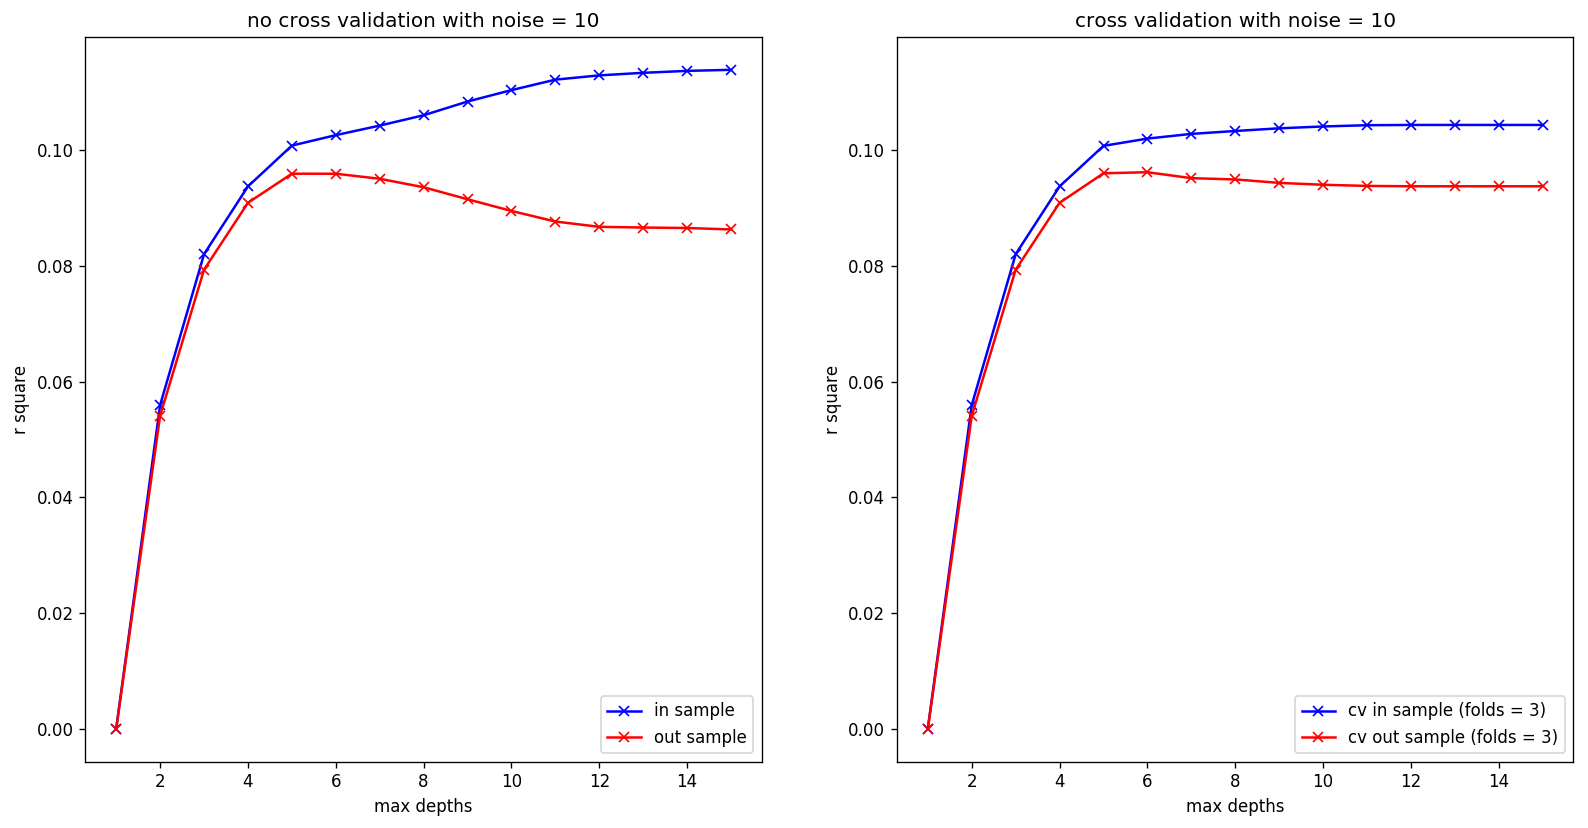

In [64]:
# plot figure1
# @ parameters: noise = 10
#               num_cv_folds = 1
#               num_cv_folds = 3 (with cross validation)
#               min_points_in_leaf = 50
#               max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.figure(figsize=(16,8),dpi= 120)

ax1 = plt.subplot(1,2,1)
plt.plot(max_depths, result1[0], '-bx', label = 'in sample')
plt.plot(max_depths, result1[1], '-rx', label = 'out sample')
plt.legend(loc = 'lower right')
plt.xlabel('max depths')
plt.ylabel('r square')
plt.title('no cross validation with noise = 10')

ax2 = plt.subplot(1,2,2, sharey = ax1)
plt.plot(max_depths, result1_cv[0], '-bx', label = 'cv in sample (folds = 3)')
plt.plot(max_depths, result1_cv[1], '-rx', label = 'cv out sample (folds = 3)')
plt.legend(loc = 'lower right')
plt.xlabel('max depths')
plt.ylabel('r square')
plt.title('cross validation with noise = 10')

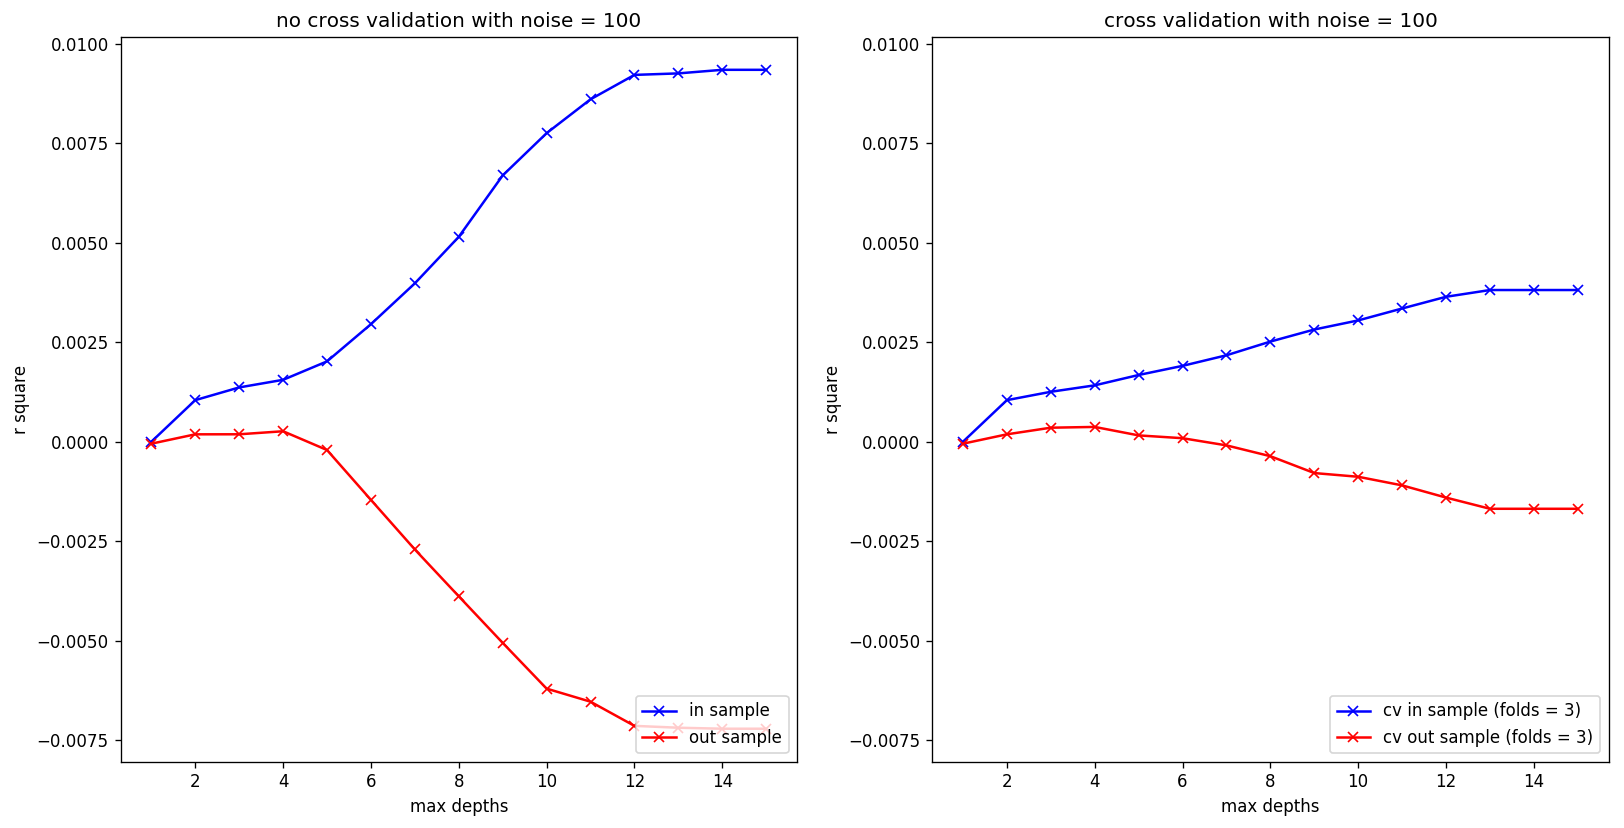

In [68]:
# plot figure2
# @ parameters: noise = 100
#               num_cv_folds = 1
#               num_cv_folds = 3 (with cross validation)
#               min_points_in_leaf = 50
#               max_depths = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.figure(figsize=(16,8),dpi= 120)

ax1 = plt.subplot(1,2,1)
plt.plot(max_depths, result2[0], '-bx', label = 'in sample')
plt.plot(max_depths, result2[1], '-rx', label = 'out sample')
plt.legend(loc = 'lower right')
plt.xlabel('max depths')
plt.ylabel('r square')
plt.title('no cross validation with noise = 100')

ax2 = plt.subplot(1,2,2, sharey = ax1)
plt.plot(max_depths, result2_cv[0], '-bx', label = 'cv in sample (folds = 3)')
plt.plot(max_depths, result2_cv[1], '-rx', label = 'cv out sample (folds = 3)')
plt.legend(loc = 'lower right')
plt.xlabel('max depths')
plt.ylabel('r square')
plt.title('cross validation with noise = 100')

<font color="red">
#### Conclusion:

It looks different, there is a gap between the $R^2$ of fit data and the new data, the new data's is smaller than fit data's, this is caused by the fact that the new data couldn't fit the tree that well as the fit data. 

And the gap becomes narrow with the existence of the cross validation. 

Meanwhile, we can notice that the $R^2$ of the fit data become smaller: the $R^2$ of the one without cross validation is a little bit higher than 0.1, and the $R^2$ of the one with cross validation is around 0.1. From this point of view, cross validation actually reduce the overfitting problem. 

Besides, the higher the noise, the bigger the difference between the new data $R^2$ and the fit data $R^2$.